## Importation des modules nécessaires à l'élaboration du projet

In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Examinons la donnée

In [2]:
attrition_data_init = pd.read_csv('/home/apprenant/PycharmProjects/Brief-10-Employees-Turnover/data/attrition_train.csv')
attrition_test_init = pd.read_csv('/home/apprenant/PycharmProjects/Brief-10-Employees-Turnover/data/attrition_test.csv')

In [3]:
# on enleve les columns qui ne comprennent qu'une seule valeur, ainsi que le numéro d'employé.
attrition_data = attrition_data_init.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'], axis =1)
attrition_test = attrition_test_init.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'], axis =1)

In [4]:
# le jeu de test comprend une colonne index qui n'est pas utile
attrition_test = attrition_test.drop('index1', axis=1)

#### Valeurs manquantes

In [5]:
attrition_data.isna().sum().sum()

0

0 valeur manquante donc RAS

## Création de notre modèle

### Encodage de nos variables catégorielles

In [10]:
cat_vars = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(attrition_data[var], prefix=var)
    data1=attrition_data.join(cat_list)
    attrition_data=data1

for var in cat_vars:
    cat_list2='var'+'_'+var
    cat_list2 = pd.get_dummies(attrition_test[var], prefix=var)
    data2=attrition_test.join(cat_list2)
    attrition_test=data2

In [11]:
attrition_data_numbers = attrition_data.drop(cat_vars, axis=1)

In [12]:
attrition_test_numbers = attrition_test.drop(cat_vars, axis=1)

In [13]:
attrition_data['Attrition'] = attrition_data['Attrition'].replace(['Yes', 'No'], [1, 0])
attrition_data_numbers = attrition_data_numbers.drop('Attrition', axis=1)

In [14]:
columns_list = attrition_data_numbers.columns

## scaling

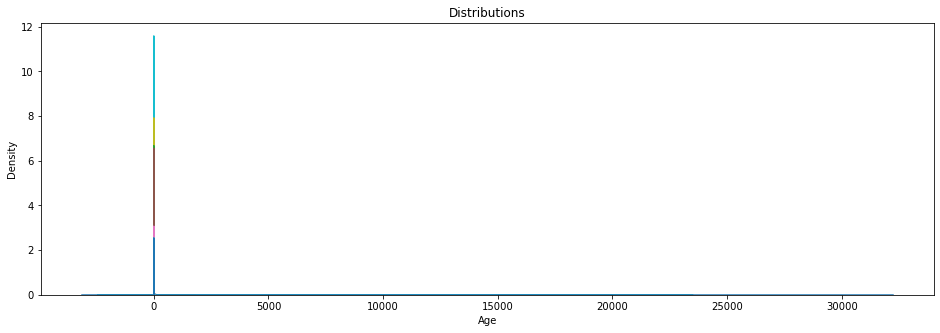

In [15]:
fig, a = plt.subplots(ncols=1, figsize=(16, 5))
a.set_title("Distributions")
for col in attrition_data_numbers.columns:
    sns.kdeplot(attrition_data_numbers[col], ax=a)
plt.show()

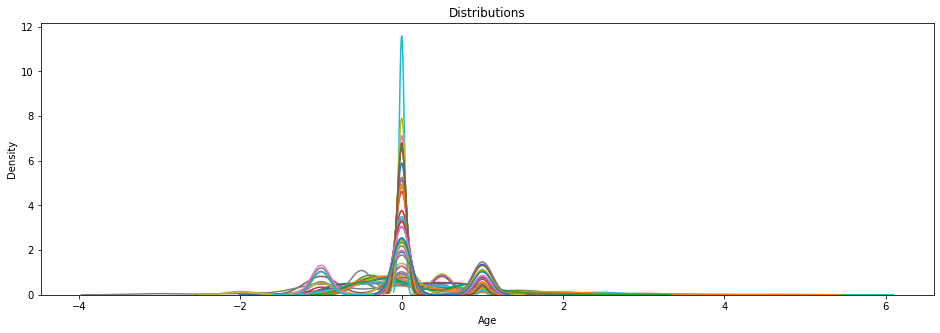

In [16]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler, MinMaxScaler,RobustScaler

# scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = RobustScaler()

scaled_df = scaler.fit_transform(attrition_data_numbers)
scaled_df = pd.DataFrame(scaled_df, columns=columns_list)

fig, a = plt.subplots(ncols=1, figsize=(16, 5))
a.set_title("Distributions")
for col in scaled_df.columns:
    sns.kdeplot(scaled_df[col], ax=a)
plt.show()

In [17]:
attrition_data_numbers = scaled_df

### Mise en place de notre modèle de régression logistique

In [18]:
y = attrition_data['Attrition']
X = attrition_data_numbers
X_pred = attrition_test_numbers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
my_model = LogisticRegressionCV(Cs = 10, cv=5, penalty = 'l2',solver='liblinear')

In [20]:
my_model.fit(X_train, y_train)

LogisticRegressionCV(cv=5, solver='liblinear')

In [21]:
prediction = my_model.predict(X_test)

In [22]:
score = my_model.score(X_test, y_test)
print('Test Accuracy Score :', score)

Test Accuracy Score : 0.8727272727272727


In [23]:
print('F-mesure :', f1_score(y_test,prediction, average="macro"))

F-mesure : 0.7298245614035088


In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[176,   8],
       [ 20,  16]])

Text(0.5, 257.44, 'Predicted label')

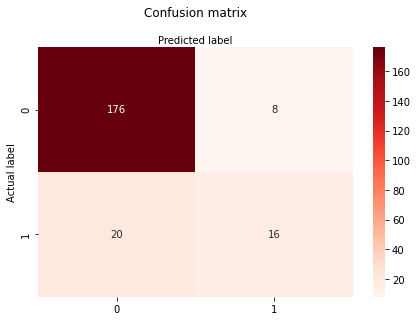

In [25]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Reds" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### ROC

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.848


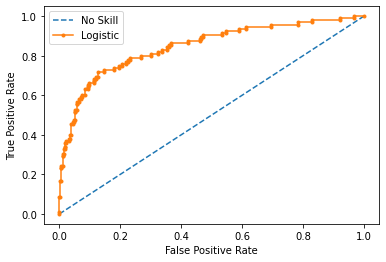

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
my_model.fit(trainX, trainy)
# predict probabilities
lr_probs = my_model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


### RFE

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [28]:
# Create the RFE object and compute a cross-validated score.
svc = LogisticRegressionCV(Cs = 10, cv=5, penalty = 'l2',solver='liblinear')
# svc=LogisticRegression(C = 10, penalty = 'l2', solver= 'liblinear')

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy',
              min_features_to_select=1)
rfecv.fit_transform(X, y)

# print(rfecv.grid_scores_)
# print(len(rfecv.grid_scores_))

array([[ 0.16326531, -0.80541696, -0.41666667, ...,  1.        ,
        -1.        ,  1.        ],
       [ 1.30612245, -0.68852459,  1.75      , ...,  0.        ,
        -1.        ,  1.        ],
       [-0.65306122,  0.95652174, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24489796, -0.41197434,  0.08333333, ...,  1.        ,
        -1.        ,  1.        ],
       [-0.57142857,  0.98503207, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.79591837, -0.29080542,  0.        , ...,  0.        ,
        -1.        ,  1.        ]])

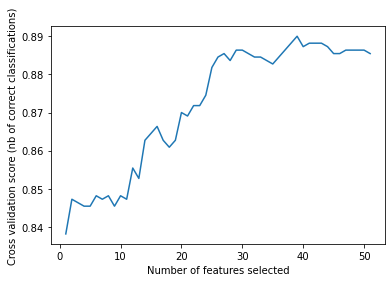

In [29]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [30]:
print("The fitted estimator used to select features: ",rfecv.estimator_)
print("The mean cross-validation score: ", rfecv.grid_scores_.mean())

The fitted estimator used to select features:  LogisticRegressionCV(cv=5, solver='liblinear')
The mean cross-validation score:  0.8719964349376113


In [31]:
print("Optimal number of features in X_RFE : %d" % rfecv.n_features_)
print("The importances of features: ",rfecv.estimator_.coef_)

Optimal number of features in X_RFE : 39
The importances of features:  [[-0.22249048 -0.17082518  0.40410127 -0.83925977  0.16493144 -0.57493439
  -0.62813875 -0.50378731  0.10146089  0.4269968  -0.53004671 -0.26323249
  -0.36151097 -0.23427442 -0.23083328  0.17783274 -0.50964186  0.48177211
  -0.42006241 -0.80897511  0.74997776  0.20194426 -0.64416109 -0.19111585
  -0.6328963  -0.690943   -0.23032743  0.23032743 -0.51742358 -0.63448759
  -0.3910315  -0.73280389 -0.29674532  0.61817261 -0.93790102 -0.79188036
  -0.18387262 -0.85585179  0.85585179]]


In [32]:
# print("The feature ranking: ",rfecv.ranking_)
print("The mask of selected features.: ",rfecv.support_)
df =pd.DataFrame(rfecv.support_,index=columns_list,columns=['Rank'])
df.value_counts()

The mask of selected features.:  [ True  True  True False  True  True  True False  True  True  True  True
 False False  True  True  True  True  True  True  True  True  True  True
  True False False False  True False  True  True  True  True False  True
  True  True False False False  True  True  True  True  True  True  True
  True  True  True]


Rank 
True     39
False    12
dtype: int64

In [33]:
df = df[df['Rank']==True]
rfecv_cols_to_keep = df.index

In [34]:
new_list = []
arr = rfecv.estimator_.coef_.tolist()

for i,x in enumerate(arr):
    for y in x: 
        new_list.append(y)

# print(new_list)

In [35]:
df2 =pd.DataFrame(index=rfecv_cols_to_keep,columns=['coef'])
df2['coef'] = new_list
df2.sort_values(by ='coef', ascending = False)

,coef
OverTime_Yes,0.855852
BusinessTravel_Travel_Frequently,0.749978
JobRole_Sales Representative,0.618173
YearsSinceLastPromotion,0.481772
NumCompaniesWorked,0.426997
DistanceFromHome,0.404101
Gender_Male,0.230327
Department_Sales,0.201944
YearsAtCompany,0.177833
HourlyRate,0.164931
